#
We run ROAD (faithfulness) from Quantus on RISE and a random baseline and get unexplainable bad results.

In [1]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
import dianna
import quantus

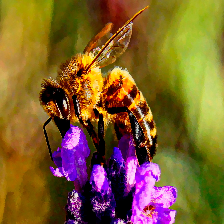

In [2]:
def load_img(path, target_size):
    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications.resnet50 import preprocess_input
    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

bee_img, bee_arr = load_img('C:/Users/ChristiaanMeijer/OneDrive - Netherlands eScience Center/Documents/dianna/dianna-exploration/example_data/xai_method_study/RISE/bee.jpg', (224,224,3))
bee_img

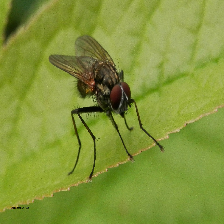

In [4]:
from pathlib import Path

reference_img, reference_arr = load_img(
    Path(r'C:\Users\ChristiaanMeijer\OneDrive - Netherlands eScience Center\Documents\dianna\dianna-exploration\notebooks_for_distance_explainer\data\fly.jpg'),
    (224, 224, 3))
reference_img


In [6]:
import matplotlib.pyplot as plt

def plot_hist(result):
    data = []
    for key, value in result.items():
        for _ in range(int(value)):
            data.append(key)

    # plot the histogram
    plt.hist(data, bins=range(0, 101, 10), align='mid')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Results')
    plt.show()

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50
model = ResNet50()

def random_xai(model, input_data, method, labels, **kwargs):
    output = np.random.randn(*input_data.shape[:-1])[None,...]
    return output

random_result = quantus.AvgSensitivity(
    nr_samples=50,
    # perturb_func=quantus.perturb_func.gaussian_noise,
)(model=model,
   x_batch=bee_arr,
   y_batch=[309],
   a_batch=None,
   explain_func= random_xai,
   explain_func_kwargs={'model_or_function': model,
                        "input_data": bee_arr[0],
                        "method": "RISE",
                        "labels": range(1),
                       }
)
print(random_result)


[1.410427713575097]


In [14]:
random_result

[1.4157706749803092]

In [23]:
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50
from distance_explainer.distance import DistanceExplainer, generate_masks_for_images
model = ResNet50()
embedded_reference = model(reference_arr)

class OurModel(tensorflow.keras.Model):
    def call(self, input_arr):
        input_prediction = model(input_arr)
        distances = DistanceExplainer.calculate_distances(input_prediction, embedded_reference)
        return distances

img_shape = bee_arr.shape[1:3]
masks = generate_masks_for_images(img_shape, 500, 0.5, 8)
distance_model = OurModel()
targets = distance_model(bee_arr)
def explain(model, inputs, targets, **kwargs) -> np.ndarray:
    """

    :param model:
    :param inputs:
    :param targets: Ignored, added because of required signature (source: https://captum.ai/api/gradient_shap.html#captum.attr.GradientShap.attribute)
    :param kwargs:
    :return:
    """
    # see C:\Users\ChristiaanMeijer\anaconda3\envs\distance_explainer311\Lib\site-packages\quantus\functions\explanation_func.py
    saliency, neutral_value = DistanceExplainer(axis_labels=['sfdgjlj', 'x','y','channels']).explain_image_distance(model, inputs, embedded_reference, masks=masks)
    return saliency

In [24]:
from pandas import DataFrame

result = []
for i in range(10):
    result.append(quantus.AvgSensitivity(
        nr_samples=1,

        # perturb_func=quantus.perturb_func.gaussian_noise,
    )(model=distance_model,

       x_batch=bee_arr,
       y_batch=[0],
       a_batch=None,
       explain_func=explain,  #model, inputs, targets, kwargs
    ))
    r_df = DataFrame(result)
    print(r_df)
    r_df.describe()


Explaining:   0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Exception encountered when calling layer 'our_model_4' (type OurModel).

Input 0 of layer "resnet50" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 500, 224, 224, 3)

Call arguments received by layer 'our_model_4' (type OurModel):
  • input_arr=tf.Tensor(shape=(1, 500, 224, 224, 3), dtype=float32)

In [16]:
from pandas import DataFrame
from tensorflow.keras.applications.resnet50 import ResNet50
model = ResNet50()
result = []
for i in range(10):
    result.append(quantus.AvgSensitivity(
        nr_samples=1,
        perturb_func_kwargs={'perturb_std':0.1*255,}
        # perturb_func=quantus.perturb_func.gaussian_noise,
    )(model=model,
       x_batch=bee_arr,
       y_batch=[309],
       a_batch=None,
       explain_func=dianna.explain_image,
       explain_func_kwargs={'model_or_function': model,
                            "input_data": bee_arr[0],
                            "method": "RISE",
                            "labels": range(1),
                            "p_keep": 0.1,
                            "n_masks": 500,
                           }
    ))
    r_df = DataFrame(result)
    print(r_df)
    r_df.describe()

ValueError: Unexpected keyword arguments encountered: {'perturb_std': 25.5}. To ensure proper usage, please refer to the 'get_params' method of the initialised metric instance or consult the Quantus documentation. Avoid passing extraneous keyword arguments. Ensure that your metric arguments are correctly structured, particularly 'normalise_func_kwargs', 'explain_func_kwargs', and 'model_predict_kwargs'. Additionally, always verify for any typos.

In [ ]:
[0.11276582301323408][0.08319267603621364]

We saw a small correlation but the number of masked pixels was less than 1% so not a lot of change in output could be expected to start with.
We try again with a larger subset size.

In [ ]:
# Average Sensitivity: RISE
from tensorflow.keras.applications.resnet50 import ResNet50
model = ResNet50()

result = quantus.FaithfulnessCorrelation(
    nr_runs=1000,
    subset_size=224*224//2

    # perturb_func=quantus.perturb_func.gaussian_noise,
)(model=model,
   x_batch=bee_arr,
   y_batch=[309],
   a_batch=None,
   explain_func=dianna.explain_image,
   explain_func_kwargs={'model_or_function': model,
                        "input_data": bee_arr[0],
                        "method": "RISE",
                        "labels": range(1),
                        "p_keep": 0.1,
                        "n_masks": 1000,
                       }
)
print(result)